<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Apriori" data-toc-modified-id="Apriori-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Apriori</a></span><ul class="toc-item"><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Implementation</a></span></li><li><span><a href="#Using-mlxtend.frequent_patterns.apriori()" data-toc-modified-id="Using-mlxtend.frequent_patterns.apriori()-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Using <code>mlxtend.frequent_patterns.apriori()</code></a></span></li></ul></li><li><span><a href="#Assocation-Rule-Learning" data-toc-modified-id="Assocation-Rule-Learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Assocation Rule Learning</a></span></li></ul></div>

In [1]:
import requests
from io import BytesIO
from PIL import Image
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file
import scipy
from tqdm.notebook import tqdm
from itertools import combinations
import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import pickle as pk
from google_drive_downloader import GoogleDriveDownloader as gdd

plt.style.use("dark_background")

tqdm.pandas()

def display_poster(if_item, then_item):
    def get_poster(movie_id):
        url = f"https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/img/POSTER_20M_FULL/{movie_id}.jpg"
        try:
            req = requests.get(url)
            b = BytesIO(req.content)
            img = np.asarray(Image.open(b))
        except:
            img = np.zeros((200, 100, 3))
        return img
    
    def get_movie_title(movie_id):
        global movies
        return movies.loc[movies["id"]==movie_id, "title"].iloc[0]
    
    if_image = get_poster(list(if_item)[0])
    if_title = get_movie_title(list(if_item)[0])
    then_image = get_poster(list(then_item)[0])
    then_title = get_movie_title(list(then_item)[0])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
    
    ax1.set_title(f"{if_title}")
    ax1.imshow(if_image)
    ax2.set_title(f"{then_title}")
    ax2.imshow(then_image)   
    
    fig.tight_layout()  

C:\Users\82104\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
movies = pd.read_csv("./Datasets/MovieLens/movies.csv", index_col=0)
genres = pd.read_csv("./Datasets/MovieLens/genres.csv", index_col=0)
gdd.download_file_from_google_drive(file_id="15vsm-VWAC3Y-7jr7ROL_xy0ufkIfqSke", dest_path="D:/ratings.csv")
ratings = pd.read_csv("D:/ratings.csv")
ratings = ratings.drop(["Unnamed: 0"], axis=1)

In [53]:
n_users = likes["user_id"].nunique()
# recent_yr = movies["release_year"].max()
# recent_movies = movies[movies["release_year"].isin(range(recent_yr - 10, recent_yr))]["id"]
# likes = ratings[(ratings["rating"]>=4.0) & (ratings["movie_id"].isin(recent_movies))]
likes = ratings[(ratings["rating"]>=4.0)]
user_likes = likes.groupby("user_id")["movie_id"].apply(set)

def support(x):
    users = user_likes[x<=user_likes].index
    return len(users)/n_users

def confidence(x, y):
    users_x = user_likes[x<=user_likes].index
    users_xy = user_likes[x|y<=user_likes].index
    return len(users_xy)/len(users_x)

def lift(x, y):
    return confidence(x, y)/support(y)

# Apriori

## Implementation

In [6]:
# max_len = 3
# min_sup = 0.01
# freq_sets = {frozenset((movie, )) for movie in ratings["movie_id"]}
# freq_set2sup = {}
# for i in range(1, max_len+1):
#     #i개 원소를 갖는 frozenset만을 고려합니다.
#     freq_sets = list(filter(lambda x : len(x) == i, freq_sets))
    
#     #frozsenset:support를 dictionary로 저장합니다.
#     freq_set2sup_temp = {}    
#     for freq_set in tqdm(freq_sets):
#         sup = round(support(freq_set), 3)
#         #min_sup보다 support가 높은 frozenset만을 선별합니다.
#         if sup >= min_sup:
#             freq_set2sup_temp[freq_set] = sup
#             print(freq_set, sup)
            
#     freq_set2sup.update(freq_set2sup_temp)
#     #원소 2개의 조합으로 만들 수 있는 모든 합집합을 만듭니다.
#     freq_sets = {a | b for a, b in combinations(freq_set2sup.keys(), 2)}

## Using `mlxtend.frequent_patterns.apriori()`

In [8]:
enc = TransactionEncoder()
user_likes_ohe = enc.fit_transform(user_likes)
user_likes_ohe = pd.DataFrame(user_likes_ohe, index=user_likes.index, columns=enc.columns_)

file = "./frequent_sets.pkl"
if os.path.exists(file):
    with open(file, "rb") as f:
        freq_sets = pk.load(f)
else:
    with open(file, "wb") as f:
        # max_len을 3이상으로 할 시 매우 많은 메모리가 필요합니다.
        freq_sets = apriori(user_likes_ohe, min_support=0.01, max_len=2, use_colnames=True, verbose=1)
        
        pk.dump(freq_sets, f)

# Assocation Rule Learning

In [46]:
asso_rules = association_rules(freq_sets, metric="confidence", min_threshold=0.01)
# Lift를 기준으로 추천합니다.
asso_rules = asso_rules.sort_values("lift", ascending=False)
asso_rules = asso_rules.drop(["leverage", "conviction"], axis=1)

id2title = {row["id"]:row["title"] for _, row in movies.iterrows()}
asso_rules.insert(1, "antecedents_title", asso_rules["antecedents"].apply(lambda x : id2title[list(x)[0]]))
asso_rules.insert(3, "consequents_title", asso_rules["consequents"].apply(lambda x : id2title[list(x)[0]]))

In [49]:
asso_rules.iloc[:40:2]

,antecedents,antecedents_title,consequents,consequents_title,antecedent support,consequent support,support,confidence,lift
11681,(86377),Louis C.K.: Shameless,(86345),Louis C.K.: Hilarious,0.013952,0.014373,0.010344,0.741379,51.580147
11674,(88140),Captain America: The First Avenger,(86332),Thor,0.021309,0.021871,0.010825,0.507996,23.227208
11916,(111362),X-Men: Days of Future Past,(112852),Guardians of the Galaxy,0.018403,0.025439,0.010063,0.546841,21.496150
11899,(106489),"Hobbit: The Desolation of Smaug, The",(98809),"Hobbit: An Unexpected Journey, The",0.018262,0.034199,0.013311,0.728869,21.312380
11919,(111759),Edge of Tomorrow,(112852),Guardians of the Galaxy,0.020969,0.025439,0.010424,0.497132,19.542103
7201,(53519),Death Proof,(54995),Planet Terror,0.024858,0.025459,0.010845,0.436290,17.136934
11807,(106487),"Hunger Games: Catching Fire, The",(91500),"Hunger Games, The",0.020888,0.038590,0.013792,0.660269,17.110049
7011,(54995),Planet Terror,(52281),Grindhouse,0.025459,0.042038,0.016358,0.642520,15.284431
11915,(109374),"Grand Budapest Hotel, The",(106920),Her,0.031493,0.023715,0.010885,0.345640,14.574718
11237,(102125),Iron Man 3,(77561),Iron Man 2,0.018463,0.039532,0.010605,0.574376,14.529491


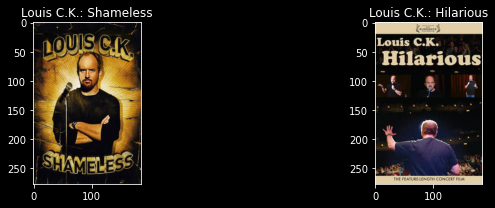

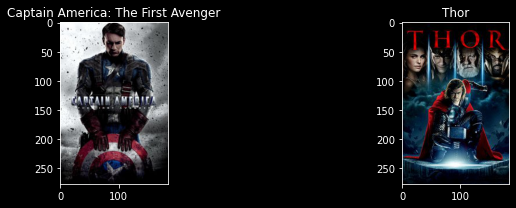

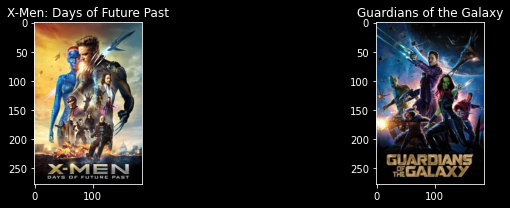

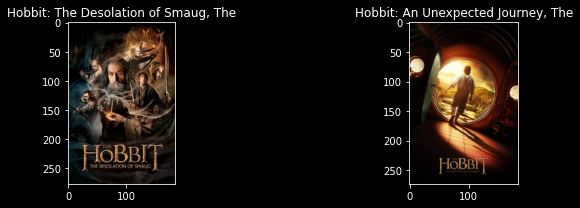

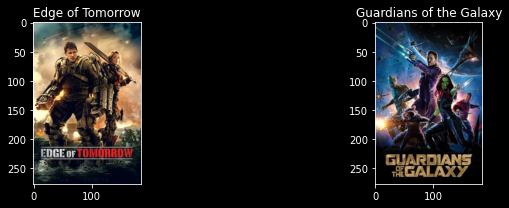

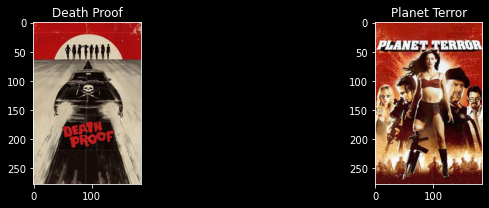

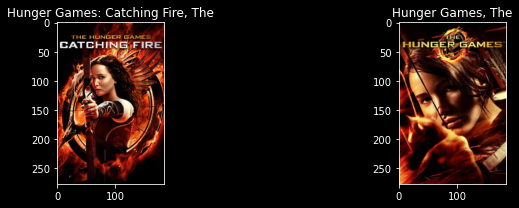

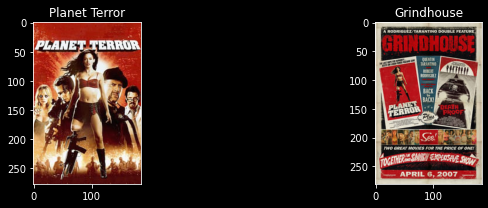

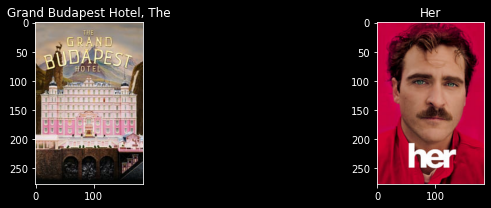

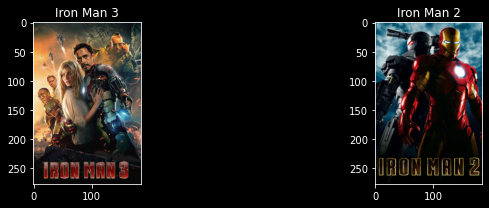

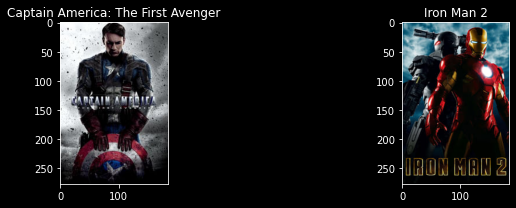

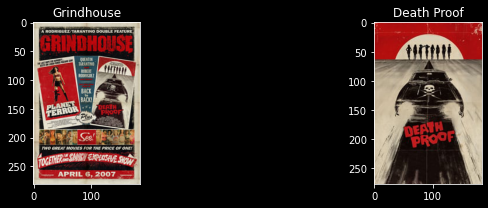

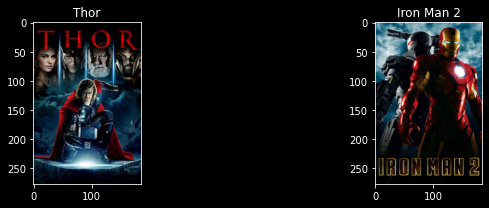

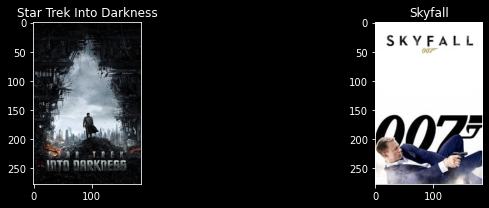

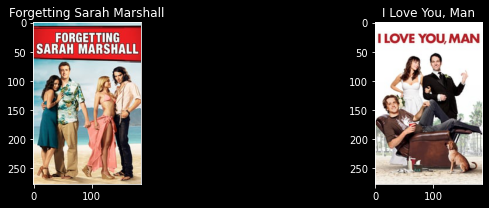

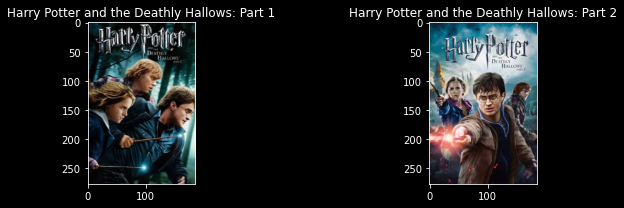

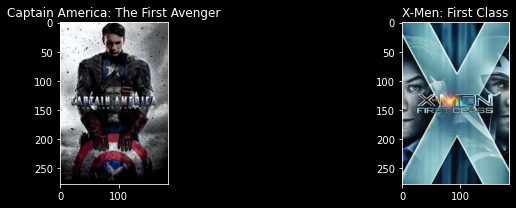

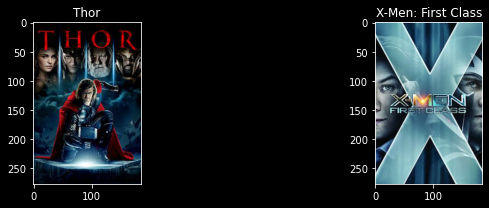

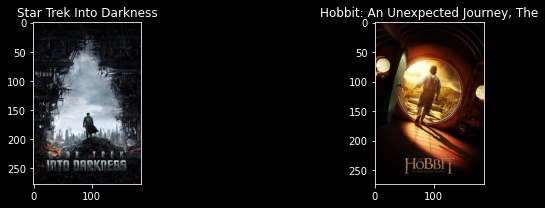

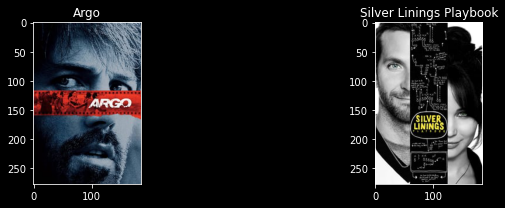

In [50]:
for _, row in asso_rules.iloc[:40:2].iterrows():
    display_poster(row["antecedents"], row["consequents"])